In [3]:
import torch
from torch.nn.functional import log_softmax
from torch.nn import NLLLoss
import torchvision
import os
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [5]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)


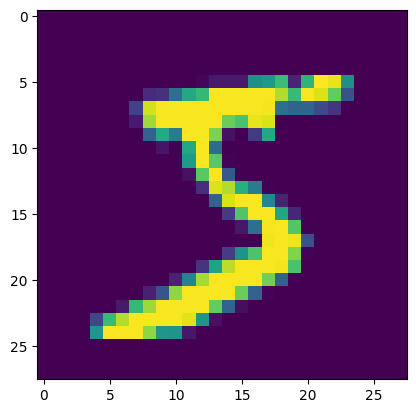

In [10]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [7]:
n_epochs = 3
losses = []
accuracies = []

def train(model, optimizer, n_epochs=n_epochs):
    for epoch in range(n_epochs):

        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            log_probs = log_softmax(y_pred, dim=1)
            loss = NLLLoss()(log_probs, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = NLLLoss()(log_softmax(y_pred), y_val)

                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
            losses.append(np.mean(val_loss))
            accuracies.append(np.mean(val_accuracy))

<span>Исходная модель:</span>

In [10]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

print(f"Количество параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Количество параметров: 47758


In [120]:
train(model, optimizer)

  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_145891/2937752172.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = NLLLoss()(log_softmax(y_pred), y_val)
100%|██████████| 157/157 [00:02<00:00, 57.54it/s]


Epoch: 0, loss: 0.04056539759039879, accuracy: 0.9867


100%|██████████| 157/157 [00:02<00:00, 55.67it/s]

Epoch: 2, loss: 0.03809841349720955, accuracy: 0.9863


<span>Получили метрику 0.9863</span>

<span>Обучим модель с тремя свёрточными слоями и большими ядрами, но небольшим количеством параметров:</span>

In [16]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((4, 4)),
    nn.Flatten(),
    nn.Linear(64*4*4, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Количество параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Количество параметров: 98378


In [17]:
train(model, optimizer, n_epochs=10)

  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_7608/2937752172.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = NLLLoss()(log_softmax(y_pred), y_val)
100%|██████████| 157/157 [00:03<00:00, 44.72it/s]


Epoch: 0, loss: 0.06291038542985916, accuracy: 0.9802


100%|██████████| 157/157 [00:03<00:00, 44.31it/s]


Epoch: 2, loss: 0.029907342046499252, accuracy: 0.9913


100%|██████████| 157/157 [00:03<00:00, 44.63it/s]


Epoch: 4, loss: 0.026233894750475883, accuracy: 0.9909


100%|██████████| 157/157 [00:03<00:00, 45.15it/s]


Epoch: 6, loss: 0.023739617317914963, accuracy: 0.9916


100%|██████████| 157/157 [00:03<00:00, 45.71it/s]


Epoch: 8, loss: 0.024824077263474464, accuracy: 0.9923


100%|██████████| 938/938 [00:34<00:00, 26.84it/s]


Получили метрику 0.9923

Посмотрим, как менялись loss и accuracy:

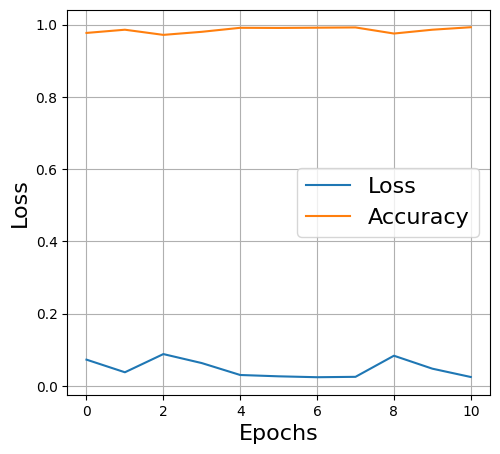

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

<span>Обучим модель с малыми ядрами, но большим количеством параметров:</span>

In [19]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((2, 2)),
    nn.Flatten(),
    nn.Linear(128*2*2, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Количество параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Количество параметров: 205802


In [20]:
train(model, optimizer, n_epochs=5)

  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_7608/2937752172.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = NLLLoss()(log_softmax(y_pred), y_val)
100%|██████████| 157/157 [00:07<00:00, 22.04it/s]


Epoch: 0, loss: 0.08327561616897583, accuracy: 0.9754


100%|██████████| 157/157 [00:06<00:00, 24.60it/s]


Epoch: 2, loss: 0.04739666357636452, accuracy: 0.986


100%|██████████| 157/157 [00:07<00:00, 22.37it/s]

Epoch: 4, loss: 0.02433834783732891, accuracy: 0.9929


Получили метрику 0.9929

<h4><b>Итоги</b></h4><p>Итак, лучший результат дала глубокая модель с малыми ядрами.</p>